<a href="https://colab.research.google.com/github/nazmus007/transformers_test/blob/main/bert_sarcpol_run1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -qq transformers

     |████████████████████████████████| 4.2 MB 28.6 MB/s 
     |████████████████████████████████| 596 kB 57.9 MB/s 
     |████████████████████████████████| 6.6 MB 53.1 MB/s 
     |████████████████████████████████| 86 kB 6.8 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import transformers

from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, BertForSequenceClassification

import torch
import re
import numpy as np
import pandas as pd

import seaborn as sns

from pylab import rcParams

import matplotlib.pyplot as plt

from matplotlib import rc

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report

from collections import defaultdict

from textwrap import wrap

from torch import nn, optim

from torch.utils.data import Dataset, DataLoader

In [4]:
import torch.nn.functional as F

In [5]:
df_train = pd.read_csv("./drive/MyDrive/datasets/sarc_pol_train.csv")
df_train.head()

,Unnamed: 0,index,Tweet,Label
0,0,0,JUST YOU SHUT THE FUCK UP AND GET BACK TO TROO...,1
1,1,1,When all else fails blame Pepe,1
2,2,2,Well at least he is doing a white people drug .,1
3,3,3,I'm sure he will come into meetings with a com...,1
4,4,4,I'm so shocked,1


In [6]:
df_test= pd.read_csv("./drive/MyDrive/datasets/sarc_pol_test.csv")

In [7]:
df_val = pd.read_csv("./drive/MyDrive/datasets/sarc_pol_dev.csv")

In [8]:
!pip install demoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 1.6 MB/s 


In [9]:
import demoji
def demoji_text(text):
  d= demoji.findall(text)
  return d

In [10]:
df_train['emoji_list'] = df_train['Tweet'].apply(demoji_text)

In [11]:
f= list(filter(None, df_train['emoji_list']))

In [12]:
print(f)

[]


In [13]:
all_keys = set().union(*(d.keys() for d in f))

In [14]:
print(all_keys)

set()


In [15]:
len(all_keys)

0

In [16]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

In [17]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
#tokenizer.add_tokens(['⭕', '♐', '👋', '👴', '🤔', '😳', '✔', '🎶', '😂', '😪', '⛽', '😤', '🏋', '💌', '🌏', '♥', '🎙', '💐', '🏇', '☃', '👑', '📄', '🙁', '🐊', '🌸', '☹', '💦', '⏲', '🙏🏽', '😉', '🍅', '🎮', '📹', '😄', '🎉', '😩', '😮', '🍂', '🙎', '😟', '😫', '🔫', '🙏', '😀', '⚡', '💁', '😅', '👎', '®', '❄', '🌧', '😌', '🏹', '✏️', '👍', '⏳', '💸', '👦', '🏽', '😖', '👼', '🐥', '🐜', '🌊', '😼', '✂️', '😰', '🍝', '💀', '🍿', '🙇', '🚣', '💎', '😍', '🍋', '👲', '🙌🏼', '🔒', '🌟', '📜', '💋', '⚽', '☀', '👋🏻', '🌌', '🏵', '🍀', '🚊', '🍣', '😊', '👳', '🙃', '😒', '🍻', '🏦', '📻', '🙄', '👩', '🌲', '🍏', '😞', '🔋', '👉', '🐸', '🙆🏻', '🆓', '🔮', '🍦', '💝', '🆙', '🚛', '😆', '☕', '🏰', '🆗', '🐣', '🌰', '🤑', '🔦', '🕸', '👅', '🅰', '🌈', '🎼', '🌝', '❗', '🔴', '🚐', '🌎', '😋', '🍟', '🌵', '💁🏼', '✖', '🍰', '🍹', '💷', '🚮', '🍇', '✅', '🏈', '👧', '👎🏼', '🤕', '👐', '🔬', '™', '🚬', '🚌', '🐼', '🚂', '👱', '📝', '‼️', '🌙', '🖊', '🍕', '😘', '💕', '🍗', '🇸🇸', '👂', '💖', '📈', '🏐', '⛄', '♥️', '🍸', '👿', '🎅', '🐱', '🤐', '🚜', '🐨', '🍚', '🎭', '⏱', '🚲', '➰', '⛪', '🍒', '😸', '🙍', '💯', '😃', '🎨', '💲', '🔷', '🗽', '👒', '🍴', '😣', '👫', '🚙', '🙂', '💈', '👈', '🐅', '🍁', '📓', '😢', '👉🏿', '🈵', '💄', '🍫', '💙', '🐍', '⚠️', '🖖', '👆', '✍', '🍑', '⛷', '♈', '🐑', '😻', '🍾', '🍍', '🎈', '😗', '✒️', '🖼', '👗', '👨', '😝', '😾', '📥', '🐧', '🌳', '❤', '😚', '🎄', '👵', '👸🏽', '➡️', '✂', '😐', '😎', '💛', '👨\u200d👩\u200d👦\u200d👦', '⬆️', '©', '❌', '⚓', '🏡', '🚡', '😡', '😱', '📀', '⛵', '🐿', '😓', '😁', '🐘', '🍔', '⭐', '🐾', '🏒', '🍼', '🎯', '🐚', '😔', '❣', '🦃', '💧', '👍🏼', '🆒', '🐟', '💍', '💪', '🚗', '💓', '😽', '🖐', '😿', '💑', '😴', '🚫', '👀', '❄️', '🍃', '✌', '🐷', '🌪', '😹', '🔓', '🌺', '😈', '😛', '🌴', '☄', '🐳', '💗', '🌻', '🐀', '😨', '😙', '💶', '😑', '🐰', '🇪🇸', '🔐', '⛈', '😶', '🇮🇹', '❓', '😦', '🌼', '🌤', '🖕🏼', '➡', '🌨', '⛸', '👪', '📖', '🍎', '👸', '🐗', '🆘', '🗣', '🎁', '🌯', '🏥', '🐏', '🔕', '😧', '🕷', '☝️', '😕', '🇯🇵', '👓', '🔥', '🍵', '✨', '🔱', '📵', '📺', '💳', '🇺🇸', '👄', '💫', '🚑', '😲', '🎆', '🙀', '😜', '📱', '🌿', '❤️', '🍭', '✏', '☺', '⚫', '🎺', '🌍', '🛏', '🎵', '0⃣', '🚘', '💣', '🏃', '😇', '🚪', '🎂', '😥', '😠', '😺', '🔞', '☝', '🌃', '🔊', '🏆', '🎊', '🍥', '🚶', '☁️', '🐔', '☔', '😯', '🌠', '👙', '🎤', '🌬', '✌️', '☮', '🦄', '💵', '🍺', '🍆', '🗑', '📤', '🕰', '😷', '🐛', '🌅', '✊', '🚔', '☹️', '🍓', '🙏🏼', '👠', '🐯', '☁', '🗿', '🎇', '💟', '💻', '💞', '🇨🇦', '✝', '🎧', '✔️', '🐒', '💁🏽', '🐮', '🌂', '1️⃣', '🌽', '✈️', '✋', '💡', '🙌', '👨\u200d👩\u200d👧\u200d👧', '🕑', '🌶', '🎎', '👶', '💩', '🏏', '🏿', '☺️', '🌞', '🙈', '💜', '👌', '🇬🇧', '🐠', '👼🏿', '☣', '☀️', '👻', '🎑', '🎹', '😭', '🌀', '🙊', '👦🏿', '😏', '🅿️', '🐻', '🎥', '👔', '🚽'])


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [18]:
token_lens = []

for txt in df_train['Tweet']:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


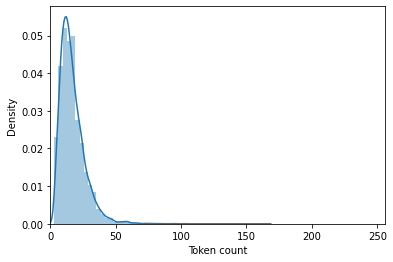

In [19]:
import seaborn as sns

sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [21]:
MAX_LEN = 128

In [22]:
class SarcasmDataset(Dataset):

  def __init__(self, tweets, targets, tokenizer, max_len):
    self.tweets = tweets
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.tweets)
  
  def __getitem__(self, item):
    tweet = str(self.tweets[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      tweet,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'tweet_text': tweet,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [20]:
df_train_X= list(df_train["Tweet"])
df_val_X = list(df_val["Tweet"])

In [21]:
y_train = list(df_train["Label"])

y_val = list(df_val["Label"])

y_test = list(df_test["Label"])

In [22]:
X_train_tokenized = tokenizer(df_train_X, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(df_val_X, padding=True, truncation=True, max_length=512)

In [27]:
train_dataset = SarcasmDataset(X_train_tokenized,tokenizer, y_train, max_len =512)
val_dataset = SarcasmDataset(X_val_tokenized, y_val)

TypeError: ignored

In [23]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [24]:
train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [26]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

#model.resize_token_embeddings(len(tokenizer))

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [27]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [28]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)


    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [29]:
output_dir='./drive/MyDrive/savedmodel_meta/sarcpol_bert'

In [30]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="steps",
    weight_decay = 0.01,
    logging_steps = 500,
    eval_steps = 500,
    logging_dir='./logs/bert_ghosh',
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    seed=123,
    load_best_model_at_end=True,
    #save_total_limit=1,
    learning_rate = 2e-5
)

In [31]:
from transformers import EarlyStoppingCallback

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args= args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,             # evaluation dataset
    tokenizer = tokenizer,
    compute_metrics = compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=20)]
)

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 10934
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5468


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
500,0.633900,0.604279,0.692758,0.753568,0.576839,0.653465
1000,0.602500,0.567207,0.711778,0.721088,0.694829,0.707715
1500,0.543300,0.610985,0.728603,0.738113,0.712309,0.724981
2000,0.450500,0.622717,0.723116,0.705060,0.771304,0.736696
2500,0.446600,0.587561,0.726774,0.704308,0.785870,0.742857
3000,0.371600,0.875918,0.723848,0.712517,0.754552,0.732932
3500,0.289000,1.039268,0.720556,0.696578,0.785870,0.738535
4000,0.329400,0.862083,0.726042,0.727074,0.727604,0.727339
4500,0.206700,1.180341,0.733723,0.727594,0.750910,0.739068
5000,0.221700,1.227653,0.728603,0.719555,0.753095,0.735943


***** Running Evaluation *****
  Num examples = 2734
  Batch size = 8
Saving model checkpoint to ./drive/MyDrive/savedmodel_meta/sarcpol_bert/checkpoint-500
Configuration saved in ./drive/MyDrive/savedmodel_meta/sarcpol_bert/checkpoint-500/config.json
Model weights saved in ./drive/MyDrive/savedmodel_meta/sarcpol_bert/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./drive/MyDrive/savedmodel_meta/sarcpol_bert/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./drive/MyDrive/savedmodel_meta/sarcpol_bert/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 2734
  Batch size = 8
Saving model checkpoint to ./drive/MyDrive/savedmodel_meta/sarcpol_bert/checkpoint-1000
Configuration saved in ./drive/MyDrive/savedmodel_meta/sarcpol_bert/checkpoint-1000/config.json
Model weights saved in ./drive/MyDrive/savedmodel_meta/sarcpol_bert/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in ./drive/MyDrive/savedmodel_meta/sa

TrainOutput(global_step=5468, training_loss=0.38998702885726116, metrics={'train_runtime': 1554.0028, 'train_samples_per_second': 28.144, 'train_steps_per_second': 3.519, 'total_flos': 3685972107861120.0, 'train_loss': 0.38998702885726116, 'epoch': 4.0})

In [32]:
X_test = list(df_test["Tweet"])
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

# Create torch dataset
test_dataset = Dataset(X_test_tokenized,y_test)

# Load trained model
model_path = "./drive/MyDrive/savedmodel_meta/sarcpol_bert/checkpoint-4000"

model = BertForSequenceClassification.from_pretrained(model_path, num_labels=2)

# Define test trainer
test_trainer = Trainer(model)

# Make prediction
raw_pred, _, _ = test_trainer.predict(test_dataset)

# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)

loading configuration file ./drive/MyDrive/savedmodel_meta/sarcpol_bert/checkpoint-4000/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.19.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file ./drive/MyDrive/savedmodel_meta/sarcpol_bert/checkpoint-4000/pytorch_model.bin
All model checkpoint weights were used when init

In [33]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, y_pred,labels=[1,0]))# chkpoint4000

              precision    recall  f1-score   support

           1       0.73      0.72      0.72      1703
           0       0.72      0.73      0.73      1703

    accuracy                           0.72      3406
   macro avg       0.72      0.72      0.72      3406
weighted avg       0.72      0.72      0.72      3406



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, y_pred,labels=[1,0]))# chkpoint4000

In [34]:
class_names = [1,0]

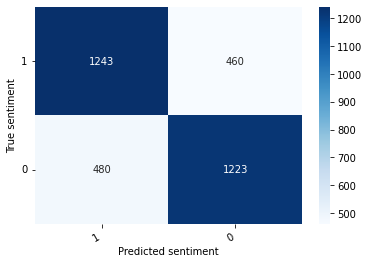

In [35]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)